In [1]:
import os
import numpy as np
from IPython.display import HTML
import string
import nltk
import re
import random

from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
from nltk.tokenize import TweetTokenizer

from HMM import unsupervised_HMM
from HMM_helper import (
    text_to_wordcloud,
    states_to_wordclouds,
    parse_observations,
    obs_map_reverser,
    sample_sentence,
    sample_sentence_backwards,
    visualize_sparsities,
    animate_emission
)

# Download Data

In [2]:
nltk.download('wordnet') 
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shawn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
text = open(os.path.join(os.getcwd(), 'data/shakespeare.txt')).read()

In [4]:
# syllable dictionary
# format the syllable dictionary
syll_dict = open(os.path.join(os.getcwd(), 'data/Syllable_dictionary.txt')).read()
syll_dict = syll_dict.splitlines()
syll_dict2 = []
for i in range(len(syll_dict)):
    syll_dict2.append(syll_dict[i].split())
syll_dict = syll_dict2

# Pre-processing

## Create obs and obs_map

In [5]:
# remove numbers denoting each sonnet
# remove capitalization
# remove apostrophes that are suffixes to a word, not part of the word

def text_lowercase(text): 
    return text.lower() 

def remove_numbers(text): 
    result = re.sub(r'\d+', '', text) 
    return result 

def remove_punctuation(text): 
    punctuation_set = ':' + ';' + ',' + '.' + '!' + '?' + '(' + ')'
    translator = str.maketrans('', '', punctuation_set)
    return text.translate(translator).replace("' ", " ")

lemmatizer = WordNetLemmatizer() 
tknzr = TweetTokenizer()
def lemmatize_word(text): 
    word_tokens = tknzr.tokenize(text) 
    # provide context i.e. part-of-speech 
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
    return lemmas 

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    # convert text to integers
    for line in lines:
        obs_elem = []
        
        for word in line:
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

# create new tokenized data and observation mapping
obs, obs_map = parse_observations(text_lowercase(remove_punctuation(remove_numbers(text))))

## Create Rhyming Dictionary

In [24]:
# read in data and remove blank lines
data = text.splitlines()
data = [string for string in data if string != ""]
poems = []
poem = []

# remove sonnet numbers and append each poem to list poems
for line in data:
    stripped = line.strip()
    if stripped.isdigit():
        if stripped != '1':
            poems.append(poem)
            poem = []
    else:
        poem.append(remove_punctuation(stripped))

# append final poem
poems.append(poem)

# remove poems that are not exactly 14 lines long
i = 1
for p in poems:
    i+=1
    if len(p) != 14:
        poems.remove(p)

# create rhyming dictionary, where each key is a word that was the last in a line,
# and the values are all the words that Shakespeare used to rhyme with the key word.
rhyme_dict = {}
for poem in poems:
    for i, line in enumerate(poem):
        # rhyme scheme is abab cdcd efef gg
        if i == 0 or i == 1 or i == 4 or i == 5 or i == 8 or i == 9:
            # look at last words of each line
            word1 = poem[i].split(' ')[-1]
            word2 = poem[i+2].split(' ')[-1]
            # add rhyming words to dictionary
            if word1 in rhyme_dict:
                if not word2 in rhyme_dict[word1]:
                    rhyme_dict[word1].append(word2)
            else:
                rhyme_dict[word1] = [word2]
                
            # add words in opposite order too
            if word2 in rhyme_dict:
                if not word1 in rhyme_dict[word2]:
                    rhyme_dict[word2].append(word1)
            else:
                rhyme_dict[word2] = [word1]
        elif i == 12:
            # look at last words of each line
            word1 = poem[i].split(' ')[-1]
            word2 = poem[i+1].split(' ')[-1]
            
            # add rhyming words to dictionary
            if word1 in rhyme_dict:
                if not word2 in rhyme_dict[word1]:
                    rhyme_dict[word1].append(word2)
            else:
                rhyme_dict[word1] = [word2]
            
            # add words in opposite order too
            if word2 in rhyme_dict:
                if not word1 in rhyme_dict[word2]:
                    rhyme_dict[word2].append(word1)
            else:
                rhyme_dict[word2] = [word1]

# Training

In [7]:
hmm10 = unsupervised_HMM(obs, 5, 10)

0
1
2
3
4
5
6
7
8
9


# Naive HMM Generation

In [8]:
# generate 14 line sonnet naively with trained HMM
for i in range(14):
    # use 8 words per line as an average
    sentence = sample_sentence(hmm10, obs_map, 8)[0:-3]
    print(sentence)

His from whose but lead men very touches
Numbers virtue hath me sorrow my than with
That great do have one of thou weary
Up nature's good to shines hour praise kings
Of the her true just if no i
That to admit not revenge all glass must
Stay doth and not sword for seem bending
Unthrift face them one give heart your hand
Never warm or then the then to wilt
To blindness thy light sweets 'twixt nimble have
Making constant crime their and sun's stars hath
Though fight of thy possession beauty's all worth
Painting unless your upon brand lets making of
Hours upon his thine both senses thy despite


## Generate sonnets with 10 syllables per line

In [9]:
syllables = 0
i = 0
num_lines = 0
poem = ''
add_last_syll = 0

while num_lines < 14: # ensure it's 14 lines in total
    # generate 10 words cuz 10 syllables/line. might not use all 10 words
    string = sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower() 
    syllables = 0
    i = 0
    line = ''
    add_last_syll = 0
    
    # generates one line
    while syllables < 10:
        word = string.split()[i]
        index = [i[0] for i in syll_dict].index(word)
        add_syll = int(syll_dict[index][-1])
        # special case for last word. ref. to syllable_dictionary.txt
        if np.shape(syll_dict[index]) == 3:
            add_last_syll = int(syll_dict[index].split()[1][1][1])
        # if last word is a special case
        if syllables + add_last_syll == 10:
            line += word
            syllables += add_last_syll
        # normal cases
        elif syllables + add_syll <= 10:
            line += word + ' '
            syllables += add_syll
            add_last_syll = 0
        # no. of syllables of last word would cause line to exceed 10 syllables. redo the whole line.
        else: 
            string = sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower() # regenerate string
            syllables = 0
            i = -1
            line = ''
            add_last_syll = 0
        i += 1
    num_lines += 1
    poem += line.capitalize() + "\n"
print(poem)


Art him of forbear things heart art to my 
And my thy to i first full do ear know 
Learn where with spite and some love my i field 
For dun love this you merit of to is 
More vouchsafe of figured with dross loss his 
Art nor one it your songs thy every and 
Within those confess striving settled let 
Thee thee boot thee they makeless quietus 
I anew in kill enrich sweet be due 
Heart away lover loved the were shall of 
Let most thus whom if against best sweet'st hides 
Debarred up not behaviour my verse place 
Present are although lord in imperfect 
Her no thy on stewards canker to it 



## Generate sonnets that follow rhyming scheme

In [10]:
poem = []
for i in range(14):
    poem.append('')

# generate 14 lined sonnet
for i in range(14):
    # seed lines with random rhyming word
    rand = random.randint(0,len(rhyme_dict)-1)
    word1 = list(rhyme_dict.keys())[rand]
    words = rhyme_dict[word1]
    word2 = words[random.randint(0,len(words)-1)]

    ind1 = obs_map[word1.lower()]
    ind2 = obs_map[word2.lower()]
    # generate 8 words backwards, seeding with the rhyming words
    line = sample_sentence_backwards(hmm10, obs_map, 7, ind1)[0:-3]
    line2 = sample_sentence_backwards(hmm10, obs_map, 7, ind2)[0:-3]
    if i == 0 or i == 1 or i == 4 or i == 5 or i == 8 or i == 9:
        poem[i] = line
        poem[i+2] = line2
    if i == 12:
        poem[i] = line
        poem[i+1] = line2

for l in poem: 
    print(l)

Evil sing unfair gilding the on praise
Prayers to very erred dearth then bereft
Interest story swear all of should days
Familiar motion over-partial to flattery say left
Sworn and state have in this possessing
Thee placed part against the then report
Of since thee cries that wink releasing
So from builded sum hours not sort
Never offices when to thou the flattery
In to were ambush they things betray
Peep weep my but and an alchemy
Time's like to i say on away
Shadows age thou for thy a they
Could my loving i to both say


## Generate sonnets that follow rhyming scheme and have 10 syllables per line

In [20]:
syllables = 0
i = 0
num_lines = 0
poem = []
for j in range(14):
    poem.append('')
add_last_syll = 0

for k in range(14):
    # seed lines with random rhyming words
    rand = random.randint(0,len(rhyme_dict)-1)
    word1 = list(rhyme_dict.keys())[rand]
    words = rhyme_dict[word1]
    word2 = words[random.randint(0,len(words)-1)]
    ind1 = obs_map[word1.lower()]
    ind2 = obs_map[word2.lower()]
    
    # generate reversed sentences so rhyming word doesn't get truncated
    # generate line for rhyming word 1
    string = sample_sentence_backwards(hmm10, obs_map, n_words=10, start_state=ind1)[0:-3].lower()
    string = ' '.join(string.split()[::-1])
    syllables = 0
    i = 0
    line = ''
    add_last_syll = 0
    # generates one line
    while syllables < 10:
        word = string.split()[i]
        index = [i[0] for i in syll_dict].index(word)
        add_syll = int(syll_dict[index][-1])
        if np.shape(syll_dict[index]) == 3: # special case for last word
            add_last_syll = int(syll_dict[index].split()[1][1][1])
        
        if syllables + add_last_syll == 10:
            line += word
            syllables += add_last_syll
        elif syllables + add_syll <= 10:
            line += word + ' '
            syllables += add_syll
            add_last_syll = 0
        else: # regenerate string
            string = sample_sentence_backwards(hmm10, obs_map, n_words=10, start_state=ind1)[0:-3].lower()
            string = ' '.join(string.split()[::-1])
            syllables = 0
            i = -1
            line = ''
            add_last_syll = 0
        i += 1
    
    # generate line for rhyming word 2
    string2 = sample_sentence_backwards(hmm10, obs_map, n_words=10, start_state=ind2)[0:-3].lower()
    string2 = ' '.join(string2.split()[::-1])
    syllables = 0
    i = 0
    line2 = ''
    add_last_syll = 0
    # generates one line
    while syllables < 10:
        word = string2.split()[i]
        index = [i[0] for i in syll_dict].index(word)
        add_syll = int(syll_dict[index][-1])
        if np.shape(syll_dict[index]) == 3: # special case for last word
            add_last_syll = int(syll_dict[index].split()[1][1][1])
        
        if syllables + add_last_syll == 10:
            line2 += word
            syllables += add_last_syll
        elif syllables + add_syll <= 10:
            line2 += word + ' '
            syllables += add_syll
            add_last_syll = 0
        else: # regenerate string
            string2 = sample_sentence_backwards(hmm10, obs_map, n_words=10, start_state=ind2)[0:-3].lower()
            string2 = ' '.join(string2.split()[::-1])
            syllables = 0
            i = -1
            line2 = ''
            add_last_syll = 0
        i += 1

    # reverse lines so that rhyming words are at the end
    line = ' '.join(line.split()[::-1])
    line2 = ' '.join(line2.split()[::-1])
    
    # append lines to follow correct rhyme scheme
    if k == 0 or k == 1 or k == 4 or k == 5 or k == 8 or k == 9:
        poem[k] = line.capitalize()
        poem[k+2] = line2.capitalize()
    if k == 12:
        poem[k] = line.capitalize()
        poem[k+1] = line2.capitalize()
        
    num_lines += 1

for l in poem: 
    print(l)

Bareness party live obsequious heaven
Are assemble more doth engraft my grief
Lived blot thoughts looking doth blood men even
For groans live now deserving youth eased thief
Spirit crown now shouldst most if and or grow'st
Fresh be i such world-without-end hear her
Speaking teach princes philomel they ow'st
My as shall happy of self fair love her
Matter lest as guilt seen away rolling
True praise do stay mine my have saith grew you
Of bent heaven certain to controlling
Or that and virtue this all finger true
Will with external would it sake mine night
See in live hied of quite grieve write delight


## Generate Haiku

In [21]:
syllables = 0
i = 0
num_lines = 0
poem = ''
add_last_syll = 0

# generate only 3 lines, with 5, 7, 5 syllables, respectively
while num_lines < 3:
    string = sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower()
    syllables = 0
    i = 0
    line = ''
    add_last_syll = 0
    num_syll = 5
    if num_lines == 1:
        num_syll = 7
    # generates one line
    while syllables < num_syll:
        word = string.split()[i]
        index = [i[0] for i in syll_dict].index(word)
        add_syll = int(syll_dict[index][-1])
        if np.shape(syll_dict[index]) == 3: # special case for last word
            add_last_syll = int(syll_dict[index].split()[1][1][1])
        
        if syllables + add_last_syll == num_syll:
            line += word
            syllables += add_last_syll
        elif syllables + add_syll <= num_syll:
            line += word + ' '
            syllables += add_syll
            add_last_syll = 0
        else: # regenerate string
            string = sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower()
            syllables = 0
            i = -1
            line = ''
            add_last_syll = 0
        i += 1
    num_lines += 1
    poem += line.capitalize() + "\n"
print(poem)

With wood old where in 
O mine she but wet prove thy 
All use loan spent seat 



# Create visualizations of transition and observation matrices

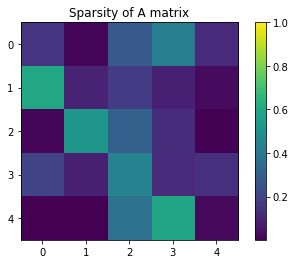

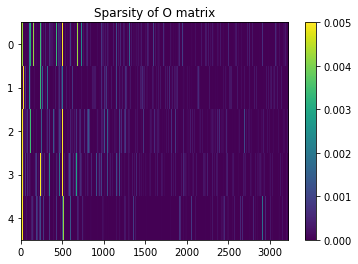

For state  0 , the most popular words are:  ['and', 'be', 'on', 'i', 'that', 'with', 'so', 'are', 'thou', 'me']
For state  1 , the most popular words are:  ['to', 'and', 'thy', 'but', 'which', 'it', 'a', 'of', 'my', 'is']
For state  2 , the most popular words are:  ['of', 'my', 'i', 'the', 'that', 'love', 'your', 'in', 'with', 'thy']
For state  3 , the most popular words are:  ['thou', 'in', 'thy', 'my', 'i', 'to', 'not', 'this', 'a', 'thee']
For state  4 , the most popular words are:  ['the', 'and', 'for', 'that', 'but', 'when', 'as', 'so', 'o', 'then']


In [22]:

visualize_sparsities(hmm10,len(hmm10.O[0]),0.005)
obs_map_r = obs_map_reverser(obs_map)
for i in range(len(hmm10.O)):
    row = hmm10.O[i]
    ordered = np.argsort(row)[::-1][0:10]
    words = []
    for j in ordered:
        max_word = obs_map_r[j]
        words.append(max_word)
    print('For state ', i, ', the most popular words are: ', words)

Generate sonnets (with rhyme, 10 syllables per line)
for the 1st 12 lines, every alternate line rhymes with each other, and the last 2 lines rhyme

In [8]:
# rhyme dictionary https://stackoverflow.com/questions/25714531/find-rhyme-using-nltk-in-python
import nltk
# nltk.download('cmudict')
def rhyme(inp, level):
    entries = nltk.corpus.cmudict.entries()
    syllables2 = [(word, syl) for word, syl in entries if word == inp]
    rhymes = []
    for (word, syllable) in syllables2:
        rhymes += [word for word, pron in entries if pron[-level:] == syllable[-level:]]
    return set(rhymes)
def doTheyRhyme(word1, word2):
  # first, we don't want to report 'glue' and 'unglue' as rhyming words
  # those kind of rhymes are LAME
    if word1.find(word2) == len(word1) - len(word2):
        return False
    if word2.find(word1) == len(word2) - len(word1): 
        return False

    return word1 in rhyme(word2, 1)
print(rhyme('may',1))


{'cluj', 'piaget', 'zepa', 'waye', 'stray', 'raye', 'mcgray', 'whey', 'lyonnais', 'waga', 'cia', 'repay', 'away', 're', 'lait', 'liberte', 'mccrea', 'hevey', 'mcray', 'underpay', 'sergei', 'brey', 'cama', 'ray', 'pray', 'beaupre', 'mcshea', 'fe', 'faberge', 'nay', 'hwe', 'dray', 'jonbenet', 'nej', 'mulvey', 'abbe', 'spey', 'bouquet', 'crochet', 'sochet', "o'shea", 'jay', 'j.', 'rene', 'slay', 'bay', 'moutray', 'shea', 'dey', 'mcclay', 'portray', 'flay', 'quay', 'yay', 'fray', 'kley', 'millay', 'banpais', 'maye', 'deseret', 'mei', 'spray', 'mccay', 'pinochet', 'toray', 'nisei', 'smay', 'cafe', 'puree', 'bombay', 'vadnais', 'roget', 'dossier', 'palais', 'prepay', 'hooray', 'stay', 'perrier', 'sevey', 'stupay', 'hay', 'shay', 'hongwei', 'faraway', 'schey', 'b-j', 'ay', 'hefei', 'shinsei', "'kay", 'wray', 'usa', 'buffet', 'morais', 'rae', 'mcnay', 'ha', 'servais', 'macknay', 'kamei', 'brae', 'lurvey', 'torme', 'frey', 'sta', 'paye', 'saye', 'benet', 'lihue', 'replay', 'blay', 'sleigh', 'le

In [10]:
obs_map.get('may')
# sample_sentence_backwards(hmm10, obs_map, 10, 23)[0:-3].lower()

446

In [ ]:
sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower()


In [ ]:
def generate_line(num_words)
    string = sample_sentence(hmm10, obs_map, n_words=num_words)[0:-3].lower()
    syllables = 0
    i = 0
    line = ''
    add_last_syll = 0
    while syllables < num_words:
        word = string.split()[i]
        index = [i[0] for i in syll_dict].index(word)
        add_syll = int(syll_dict[index][-1])
        if np.shape(syll_dict[index]) == 3: # special case for last word
            add_last_syll = int(syll_dict[index].split()[1][1][1])
        
        if syllables + add_last_syll == 10:
            line += word
            syllables += add_last_syll
        elif syllables + add_syll <= 10:
            line += word + ' '
            syllables += add_syll
            add_last_syll = 0
        else: # regenerate string
            string = sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower()
            syllables = 0
            i = -1
            line = ''
            add_last_syll = 0
            print('restart')
        i += 1
    return line

syllables = 0
i = 0
num_lines = 0
poem = ''
add_last_syll = 0
# string = sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower() + ' ' 
# each line is unlikely to have >10 words
# print(string)

while num_lines < 14:
    if num_lines == 0:
        string = sample_sentence(hmm10, obs_map, n_words=10)[0:-3].lower()